Author: Brent White, 2018

In [1]:
import pandas as pd
import numpy as np
import talib
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.rcParams['figure.figsize'] = [10, 5]

# Load daily S&P 500 data since 1993

In [2]:
spy_df = pd.read_csv('/Users/Brent/Downloads/SPY (2).csv') # change directory to your specific machine

In [3]:
spy_df['Date'] = pd.to_datetime(spy_df['Date'])
spy_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.9687,43.9687,43.7500,43.9375,26.954851,1003200
1,1993-02-01,43.9687,44.2500,43.9687,44.2500,27.146563,480500
2,1993-02-02,44.2187,44.3750,44.1250,44.3437,27.204052,201300
3,1993-02-03,44.4062,44.8437,44.3750,44.8125,27.491642,529400
4,1993-02-04,44.9687,45.0937,44.4687,45.0000,27.606684,531500


# Returns are distributed log-normal, so take the log of the adjusted close

In [4]:
spy_df['log_price'] = np.log(spy_df['Adj Close'])

# Denoise data by taking exponential moving average over various intervals

In [5]:
for i in [30,60,90,252]:
    spy_df['ema{0}'.format(i)] = talib.EMA(spy_df['log_price'], timeperiod=i)

Text(0,0.5,'log-price, log($)')

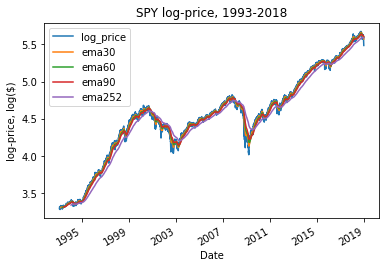

In [6]:
ax = spy_df.plot(x='Date', y=['log_price', 'ema30', 'ema60', 'ema90', 'ema252'], title='SPY log-price, 1993-2018')
ax.set_ylabel('log-price, log($)')

# When the 252-day EMA crosses over the 30-day EMA, it seems to be a good indicator of a recession... let's test this hypothesis

First, calculate daily change in log price

In [7]:
spy_df['day_pct_change'] = (spy_df['Adj Close']/spy_df['Adj Close'].shift(1)).shift(-1)
spy_df['log_price_change'] = spy_df['log_price'] - spy_df['log_price'].shift(1)

Now, drop NAs

In [8]:
spy_df = spy_df.dropna()

Show if there is mean difference in returns between periods where EMA 252 < EMA 90

In [9]:
ema30returns = spy_df.loc[(spy_df['ema30'] > spy_df['ema252']), 'log_price_change'].values
ema252returns = spy_df.loc[(spy_df['ema30'] <= spy_df['ema252']), 'log_price_change'].values
#consider if variances  equal
print('30 day crossover on top mean, stdev:', round(ema30returns.mean(), 4), round(ema30returns.std(), 4))
print('252 day crossover on top mean, stdev:', round(ema252returns.mean(), 4), round(ema252returns.std(), 4))

30 day crossover on top mean, stdev: 0.0005 0.0094
252 day crossover on top mean, stdev: -0.0004 0.0186


In [10]:
stats.ttest_ind(ema30returns, ema252returns)

Ttest_indResult(statistic=2.3028658752086018, pvalue=0.02131897726922946)

# p < 0.05, so reject the null hypothesis that returns are the same between EMA 252 and EMA 30 crossover periods

Exploring our potential returns, if we invest in a savings account during periods where the EMA 252 exceeds the EMA 30...

In [11]:
spy_df['strategy_pct_change'] = spy_df['day_pct_change'].where(spy_df['ema30'] > spy_df['ema252'], 1+(.01/252))
spy_df['Strategy Adj Close'] = spy_df['strategy_pct_change'].cumprod()*spy_df['Adj Close'].iloc[0]

Text(0,0.5,'Price, $')

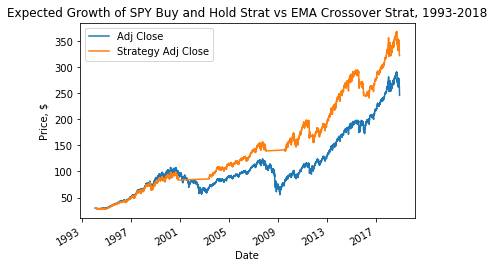

In [12]:
ax = spy_df.plot('Date', ['Adj Close', 'Strategy Adj Close'], title='Expected Growth of SPY Buy and Hold Strat vs EMA Crossover Strat, 1993-2018')
ax.set_ylabel('Price, $')

In [13]:
print('P/L Difference: {0}%'.format(
    round((spy_df['Strategy Adj Close'].iloc[-1]/spy_df['Strategy Adj Close'].iloc[0]
    - spy_df['Adj Close'].iloc[-1]/spy_df['Adj Close'].iloc[0])*100,2)))

P/L Difference: 245.38%


# Takeaway: The dotcom bubble and housing crisis could have been meandered with a simple analysis of EMA crossovers!

# By avoiding these two downturns, our theoretical S&P 500 holdings gained an additional 245.38%, compared to a buy and hold strategy, over the period from 1993 - 2018.

# With turbid waters seemingly ahead, this strategy could be of interest to you.